In [4]:
import patsy
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
#plt.style.available
#https://people.duke.edu/~ccc14/sta-663/PyMC3.html

In [5]:
plt.style.use("seaborn")

In [6]:
mtcars = pd.read_csv("../mtcars.csv", index_col = 0)

In [7]:
mtcars.head()

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


In [8]:
from pymc3.glm import glm

In [6]:
?glm

In [ ]:
?pm.glm.glm

In [9]:
with pm.Model() as model_glm:
    glm(formula = 'am ~ mpg + wt', data =  mtcars, family = pm.glm.families.Binomial() )
    trace = pm.sample(100000)

/home/jonathan/miniconda3/lib/python3.6/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -58.715: 100%|██████████| 200000/200000 [00:13<00:00, 14528.35it/s]
Finished [100%]: Average ELBO = -58.618
100%|██████████| 100000/100000 [05:16<00:00, 315.64it/s]


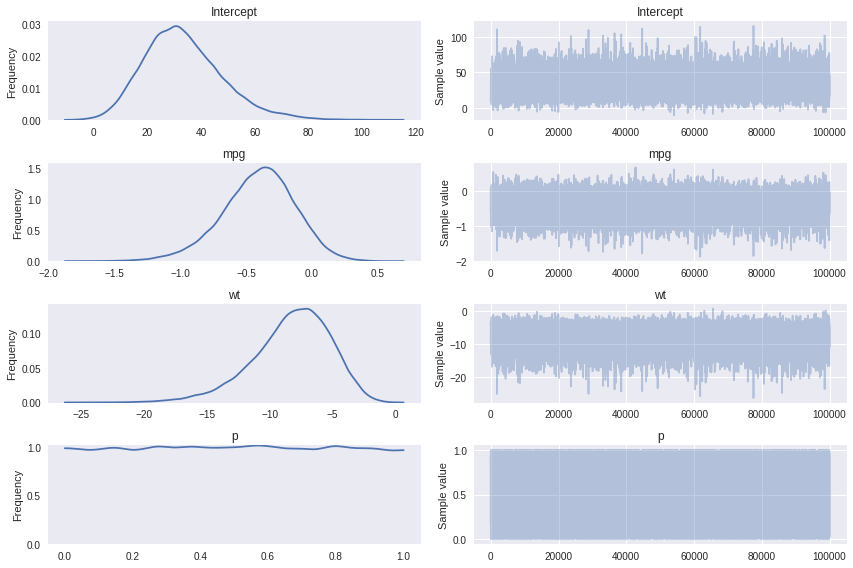

In [10]:
pm.traceplot(trace);
plt.show()

In [11]:
pm.summary(trace=trace)


Intercept:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  33.428           14.586           0.190            [6.284, 62.610]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  8.866          23.278         32.001         42.067         66.665


mpg:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.407           0.279            0.003            [-0.980, 0.120]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -1.008         -0.579         -0.391         -0.219         0.099


wt:

  Mean             SD               MC Error         95% HPD interval
  -----------------------

In [14]:
coeff = pm.df_summary(trace =trace, alpha=0.97)
coeff['mean']

Intercept    33.427745
mpg          -0.407209
wt           -8.319547
p             0.499878
Name: mean, dtype: float64

In [15]:
hpdCI = pm.stats.hpd(pymc3_obj=trace)
print("Coefficient: [2.5%, 97.5%]")
for k, vals in hpdCI.items():
    print(f"{k}: {vals}")

Coefficient: [2.5%, 97.5%]
Intercept: [  6.28354215  62.60970641]
mpg: [-0.98001695  0.12022666]
wt: [-14.4989836   -2.64326132]
p_logodds_: [-3.69996933  3.61728682]
p: [  8.62589123e-04   9.49237245e-01]


In [16]:
model = 'am ~ mpg + wt'
def predict(trace, formula, data):
    summary = pm.df_summary(trace = trace, alpha = 0.05)
    coeff = summary['mean'][:-1]
    y, x = patsy.dmatrices(data=data, formula_like=formula)
    x = x.dot(coeff)
    probs = np.exp(x) / (1 + np.exp(x))
    return probs
    
    
    

In [17]:
pm.stats.bpic(model=model_glm, trace=trace) ## predictive BIC

121.00461642746745

In [18]:
pred = predict(trace = trace, formula = model, data = mtcars)

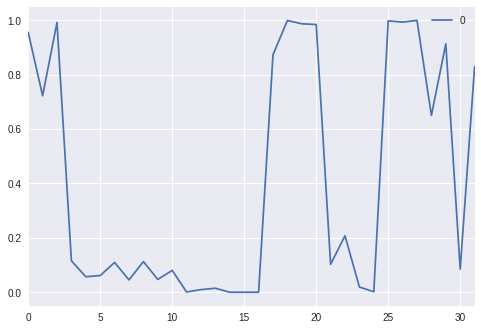

In [19]:
pred = pd.DataFrame(pred)
pred.plot()
plt.show()

In [25]:
designmatrix = patsy.dmatrix("mpg + wt", data = mtcars)

In [59]:
di = designmatrix.design_info
print(di)

DesignInfo(['Intercept', 'mpg', 'wt'],
           factor_infos={EvalFactor('mpg'): FactorInfo(factor=EvalFactor('mpg'),
                                    type='numerical',
                                    state=<factor state>,
                                    num_columns=1),
                         EvalFactor('wt'): FactorInfo(factor=EvalFactor('wt'),
                                    type='numerical',
                                    state=<factor state>,
                                    num_columns=1)},
           term_codings=OrderedDict([(Term([]),
                                      [SubtermInfo(factors=(),
                                                   contrast_matrices={},
                                                   num_columns=1)]),
                                     (Term([EvalFactor('mpg')]),
                                      [SubtermInfo(factors=(EvalFactor('mpg'),),
                                                   contrast_matrices={},


In [27]:
est = coeff['mean'][:-1]
est

Intercept    33.502255
mpg          -0.408801
wt           -8.334838
Name: mean, dtype: float64